### Import the libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os

### Define image size and data generators

In [4]:
# Image dimensions
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation/test

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    "train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"  # Binary classification (Normal vs Pneumonia)
)

val_generator = val_datagen.flow_from_directory(
    "val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_generator = val_datagen.flow_from_directory(
    "test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Load the Densenet-121 Model

In [5]:
# Load pre-trained DenseNet121 without the top classification layer
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the base model (so its weights won't be updated during training)
base_model.trainable = False

# Add Custom Layers on top
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)  # Binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Display model summary
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 21s 1us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

### Train the model

In [6]:
# Define training parameters
EPOCHS = 10

# Train the model
history = model.fit(    
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


/Users/lnt/anaconda3/envs/ml/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7677 - loss: 0.5174

/Users/lnt/anaconda3/envs/ml/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - accuracy: 0.7681 - loss: 0.5166 - val_accuracy: 0.8125 - val_loss: 0.4859
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.9056 - loss: 0.2474 - val_accuracy: 0.8125 - val_loss: 0.4703
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 419s 3s/step - accuracy: 0.9167 - loss: 0.2195 - val_accuracy: 0.8125 - val_loss: 0.4579
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 448s 3s/step - accuracy: 0.9328 - loss: 0.1767 - val_accuracy: 0.8750 - val_loss: 0.3470
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.9316 - loss: 0.1677 - val_accuracy: 0.8750 - val_loss: 0.3424
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.9441 - loss: 0.1492 - val_accuracy: 0.8750 - val_loss: 0.2894
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 446s 3s/step - accuracy: 0.9388 - loss: 0.1645 - val_accuracy: 0.8750 - val_loss: 0.3002
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 411s 3s/step - accuracy: 0.9486 - loss: 0.1479 - val_accuracy: 0.812

### Evaluate on test set

In [7]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7306 - loss: 0.5582
Test Accuracy: 0.8365


### Plot training performance

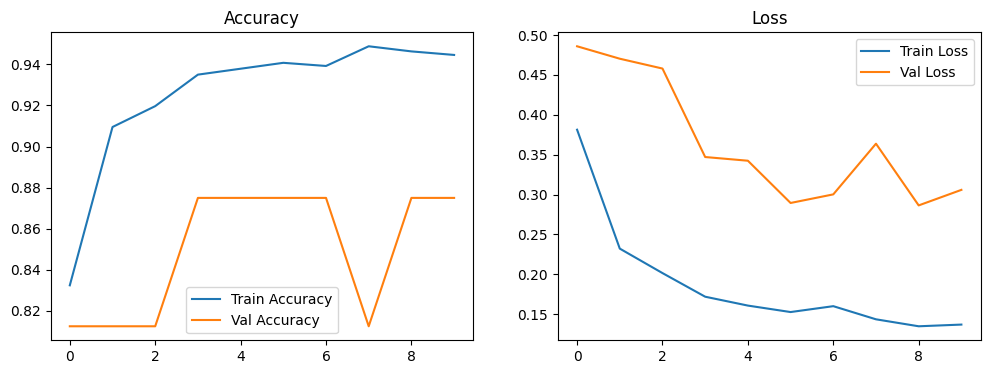

In [8]:
# Plot Accuracy & Loss
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


Classification report 

In [10]:
from sklearn.metrics import classification_report

# Get true labels and predictions
true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys())
print(report)

20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step
              precision    recall  f1-score   support

      NORMAL       0.91      0.63      0.74       234
   PNEUMONIA       0.81      0.96      0.88       390

    accuracy                           0.84       624
   macro avg       0.86      0.79      0.81       624
weighted avg       0.85      0.84      0.83       624



### Make Predictions on New Chest X-ray Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


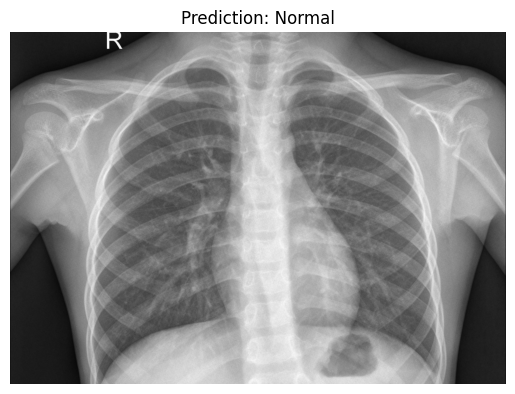

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


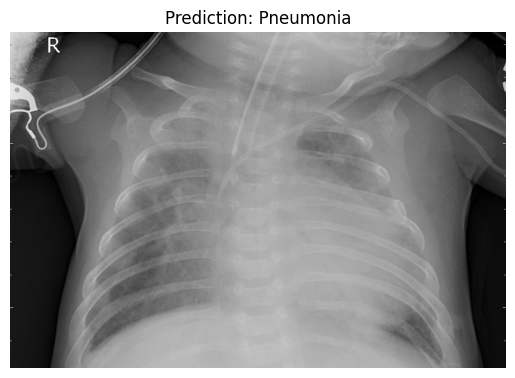

In [14]:
import cv2

def predict_image(image_path, model):
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Expand dimensions for model input

    prediction = model.predict(img)
    
    if prediction[0][0] > 0.5:
        label = "Pneumonia"
    else:
        label = "Normal"
    
    # Display Image & Prediction
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {label}")
    plt.axis("off")
    plt.show()

# Example usage
predict_image("/Users/lnt/Desktop/Uni/2year_AdvancedMachineLearning/Project/test/NORMAL/IM-0001-0001.jpeg", model)
predict_image("/Users/lnt/Desktop/Uni/2year_AdvancedMachineLearning/Project/test/PNEUMONIA/person1_virus_6.jpeg", model)
